In [16]:
import numpy as np
from numba import njit, prange
import time
from scipy.stats import linregress, theilslopes
import cupy as cp
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Final Code

In [45]:
TRANSFORMATIONS = np.array([
    [[0, -1], [1, 0]],     # 90° Rotation
    [[-1, 0], [0, -1]],    # 180° Rotation
    [[0, 1], [-1, 0]],     # 270° Rotation
    [[1, 0], [0, -1]],     # Reflection x-axis
    [[-1, 0], [0, 1]],     # Reflection y-axis
    [[0, 1], [1, 0]],      # Reflection x=y
    [[0, -1], [-1, 0]],    # Reflection x=-y
], dtype=np.float64)

@njit
def initialize_saws(L):
    "returns straight line SAWS of different directions of length L"
    saws = np.zeros((4, L+1, 2), dtype=np.float64)
    for i in range(L+1):
        saws[0, i] = [0, i]     # Up
        saws[1, i] = [0, -i]    # Down
        saws[2, i] = [i, 0]     # Right
        saws[3, i] = [-i, 0]    # Left
    return saws

@njit
def apply_transformation(walk, pivot_index, transformation_matrix):
    new_walk = walk.copy()
    pivot_point = walk[pivot_index] # coordinates of the pivot pt
    for i in range(pivot_index + 1, len(walk)):
        rel = walk[i] - pivot_point 
        # apply transformation_matrix 
        new_walk[i] = (transformation_matrix @ rel) + pivot_point
    return new_walk

@njit
def check_self_avoidance(walk):
    seen = set() # uses a set to check for self-avoidance
    for i in range(walk.shape[0]):
        key = (int(walk[i, 0]), int(walk[i, 1]))
        if key in seen:
            return False
        seen.add(key)
    return True

@njit(parallel=True)
def monte_carlo_parallel(num_samples, L):
    "generates (num_samples) of samples of length L using the pivot+ algo"
    saws = initialize_saws(L)
    samples = np.zeros((num_samples, L+1, 2), dtype=np.float64)
    # pivots = np.full(num_samples, -1, dtype=np.int32)  # default -1 = initial
    # transformations = np.full(num_samples, -1, dtype=np.int32)  # default -1 = initial

    per_chain = num_samples // 4

    # each straight line SAW (of different direction) is modified independently
    for chain in prange(4):
        current_walk = saws[chain].copy()
        count = 0
        index_base = chain * per_chain

        samples[index_base + count] = current_walk
        # pivots[index_base + count] = -1
        # transformations[index_base + count] = -1
        count += 1

        while count < per_chain:
            # chooses a pivot point
            pivot = np.random.randint(1, L)
            # chooses a transformation matrix
            t_idx = np.random.randint(0, len(TRANSFORMATIONS))
            T = TRANSFORMATIONS[t_idx]
            transformed_walk = apply_transformation(current_walk, pivot, T)

            if check_self_avoidance(transformed_walk):
                current_walk = transformed_walk
                samples[index_base + count] = current_walk
                # pivots[index_base + count] = pivot
                # transformations[index_base + count] = t_idx
                count += 1

    return samples

@njit
def concatenate_saws(walk1, walk2):
    """Translate walk2 so that it starts where walk1 ends, then concatenate."""
    endpoint = walk1[-1]  # Get the last point of walk1
    translation_vector = endpoint - walk2[0]  # Calculate how much to shift walk2
    translated_walk2 = walk2 + translation_vector  # Apply the shift

    # Concatenate the translated second walk onto the first
    concatenated_walk = np.vstack((walk1, translated_walk2[1:]))

    return concatenated_walk

@njit(parallel = True)
def compute_B(samples):
    """Estimate B(L1, L2) by checking valid concatenations of independent SAWs."""
    N = len(samples)
    Lp1 = samples.shape[1]
    valid_flags = np.zeros(N, dtype=np.uint8)

    for k in prange(N):
        # draw a random pair (i,j) uniformly from [0..N-1]
        i = np.random.randint(N)
        j = np.random.randint(N)
        
        # build the concatenated walk
        concatenated = concatenate_saws(samples[i], samples[j])
        # test self-avoidance of the concatenated walk
        if check_self_avoidance(concatenated):
            valid_flags[k] = 1

    # K tests were done
    # so B ≈ (valid/K)
    return np.mean(valid_flags)

@njit(parallel = True)
def large_recursive(initial_L, initial_c_L, iterations, N):
    "uses the recursive method to obtain log(c_L)"
    "log(c_L), L values will be used to find mu"
    L = initial_L
    log_cL = np.log(initial_c_L)
    count = 1

    Ls = np.zeros(iterations+1, dtype = np.float64)
    cLs = np.zeros(iterations+1, dtype = np.float64)

    Ls[0] = L
    cLs[0] = log_cL
    
    while count <= iterations:
        print("iterations", count)
        
        samples = monte_carlo_parallel(N, L)
        proportion = compute_B(samples)
        
        log_cL = np.log(proportion) +  (2 * log_cL)
        L = 2*L
        
        print(log_cL, L)
        
        Ls[count] = L
        cLs[count] = log_cL
        count += 1
    return cLs, Ls

In [46]:
def ln_estimate_mu(Ls, log_cLs):
    "uses regression to estimate mu"
    # Given data
    # log_cL = np.array([...])
    # L = np.array([...])
    
    # Construct your y and predictors
    y = log_cLs / Ls
    x1 = 1 / Ls
    x2 = np.log(Ls) / Ls
    
    # Stack predictors and add constant for intercept (log u)
    X = np.column_stack((x1, x2))
    X = sm.add_constant(X)  # adds intercept term
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    
    # Extract coefficients
    intercept, beta1, beta2 = model.params
    u = np.exp(intercept)
    
    return u

## Recursion using initial_L = 20. Final_L = 5120.

In [4]:
start_time = time.time()
m1test_ln_cLs_20, m1test_Ls_20 = large_recursive(20, 897697164, 8, 10**6)
total_time = time.time() - start_time  # Calculate the total time
print(f"Total time for large_recursive: {total_time:.4f} seconds")

iterations 1
40.26409951619261 40
iterations 2
79.33821788668602 80
iterations 3
157.25995845526657 160
iterations 4
312.8592541224235 320
iterations 5
623.8375896392992 640
iterations 6
1245.5621644072341 1280
iterations 7
2488.768374589816 2560
iterations 8
4974.93384247064 5120
Total time for large_recursive: 613.1523 seconds


In [13]:
m1test_Ls_20, m1test_ln_cLs_20

(array([  20.,   40.,   80.,  160.,  320.,  640., 1280., 2560., 5120.]),
 array([  20.61534334,   40.26409952,   79.33821789,  157.25995846,
         312.85925412,  623.83758964, 1245.56216441, 2488.76837459,
        4974.93384247]))

In [47]:
# estimates of mu using mu = c_L ^ (1\L)
np.exp( m1test_ln_cLs_20 / m1test_Ls_20)

array([2.80321554, 2.73628863, 2.6958882 , 2.67212688, 2.65829561,
       2.65049452, 2.64612271, 2.64368862, 2.64234496])

In [39]:
# estimates \mu using linear regression
ln_estimate_mu(m1test_Ls_20, m1test_ln_cLs_20)

np.float64(2.6408310742871124)

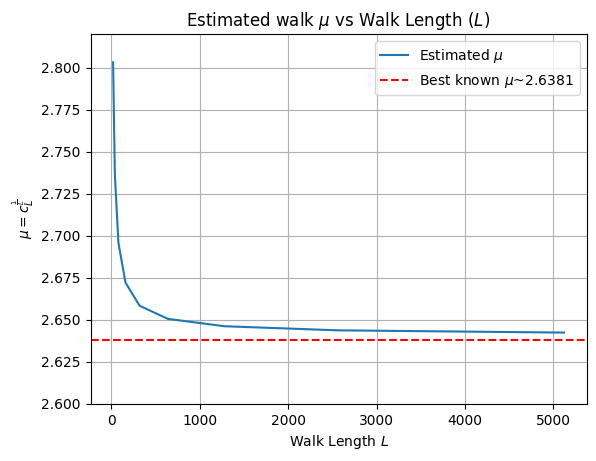

In [50]:
plt.plot(
    m1test_Ls_20, 
    np.exp( m1test_ln_cLs_20 / m1test_Ls_20),
    label = r"Estimated $ \mu $"
)
plt.axhline(y = 2.6381, color = "r", linestyle = "--", label = r"Best known $\mu$~2.6381")
plt.title(r"Estimated walk $\mu$ vs Walk Length $(L)$")
plt.grid(True)
plt.legend()
plt.xlabel(r"Walk Length $L$")
plt.ylabel(r"$ \mu = c_{L} ^{\frac{1}{L}} $")
plt.ylim((2.60, 2.82))
# plt.savefig("C:\\Users\\Admin\\Downloads\\initial_L=20.png")
plt.show()

## Recursion using initial_L = 27. Final_L = 6912.

In [7]:
start_time = time.time()
m1test_ln_cLs_27, m1test_Ls_27 = large_recursive(27, 881317491628, 8, 10**6)
total_time = time.time() - start_time  # Calculate the total time
print(f"Total time for large_recursive: {total_time:.4f} seconds")

iterations 1
53.94080520384932 54
iterations 2
106.5927113237831 108
iterations 3
211.66260728653887 216
iterations 4
421.57562914394424 432
iterations 5
841.1630969985705 864
iterations 6
1680.0908936509525 1728
iterations 7
3357.718493404853 3456
iterations 8
6712.741166517461 6912
Total time for large_recursive: 1072.9869 seconds


In [11]:
m1test_Ls_27, m1test_ln_cLs_27

(array([  27.,   54.,  108.,  216.,  432.,  864., 1728., 3456., 6912.]),
 array([  27.50468377,   53.9408052 ,  106.59271132,  211.66260729,
         421.57562914,  841.163097  , 1680.09089365, 3357.7184934 ,
        6712.74116652]))

In [48]:
# estimates of mu using mu = c_L ^ (1\L)
np.exp( m1test_ln_cLs_27 / m1test_Ls_27 )

array([2.76956977, 2.71530368, 2.68309116, 2.6642417 , 2.65347343,
       2.64737451, 2.64395215, 2.64206832, 2.64103806])

In [40]:
# estimates \mu using linear regression
ln_estimate_mu(m1test_Ls_27, m1test_ln_cLs_27 )

np.float64(2.639891168753224)

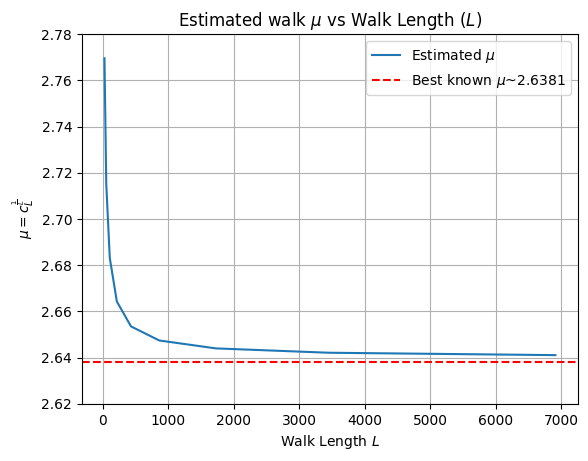

In [49]:
plt.plot(
    m1test_Ls_27, 
    np.exp( m1test_ln_cLs_27 / m1test_Ls_27),
    label = r"Estimated $ \mu $"
)
plt.axhline(y = 2.6381, color = "r", linestyle = "--", label = r"Best known $\mu$~2.6381")
plt.title(r"Estimated walk $\mu$ vs Walk Length $(L)$")
plt.grid(True)
plt.legend()
plt.xlabel(r"Walk Length $L$")
plt.ylabel(r"$ \mu = c_{L} ^{\frac{1}{L}} $")
plt.ylim((2.62, 2.78))
# plt.savefig("C:\\Users\\Admin\\Downloads\\initial_L=27.png")
plt.show()

# Preliminary Codes

## Recursion method after using standard pivot+ algo

In [3]:
TRANSFORMATIONS = np.array([
    [[0, -1], [1, 0]],     # 90° Rotation
    [[-1, 0], [0, -1]],    # 180° Rotation
    [[0, 1], [-1, 0]],     # 270° Rotation
    [[1, 0], [0, -1]],     # Reflection x-axis
    [[-1, 0], [0, 1]],     # Reflection y-axis
    [[0, 1], [1, 0]],      # Reflection x=y
    [[0, -1], [-1, 0]],    # Reflection x=-y
], dtype=np.float64)

@njit
def initialize_random_saw(L):
    """Randomly initialize a straight-line SAW in one of four directions."""
    direction = np.random.randint(0, 4)
    saw = np.zeros((L+1, 2), dtype=np.float64)
    if direction == 0:   # Up
        saw[:, 1] = np.arange(L+1)
    elif direction == 1: # Down
        saw[:, 1] = -np.arange(L+1)
    elif direction == 2: # Right
        saw[:, 0] = np.arange(L+1)
    else:                # Left
        saw[:, 0] = -np.arange(L+1)
    return saw


@njit
def apply_transformation(walk, pivot_index, transformation_matrix):
    new_walk = walk.copy()
    pivot_point = walk[pivot_index]
    for i in range(pivot_index + 1, len(walk)):
        rel = walk[i] - pivot_point
        new_walk[i] = (transformation_matrix @ rel) + pivot_point
    return new_walk

@njit
def check_self_avoidance(walk):
    seen = set()
    for i in range(walk.shape[0]):
        key = (int(walk[i, 0]), int(walk[i, 1]))
        if key in seen:
            return False
        seen.add(key)
    return True

@njit
def monte_carlo_parallel(num_samples, L):
    current_walk = initialize_random_saw(L)
    N = num_samples // 4
    samples = np.zeros((N, L+1, 2), dtype=np.float64)
    # pivots = np.full(num_samples, -1, dtype=np.int64)  # default -1 = initial
    # transformations = np.full(num_samples, -1, dtype=np.int64)  # default -1 = initial
    count = 0

    samples[count] = current_walk
    # pivots[count] = -1
    # transformations[count] = -1
    count += 1

    while count < N :
        pivot = np.random.randint(1, L)
        t_idx = np.random.randint(0, len(TRANSFORMATIONS))
        T = TRANSFORMATIONS[t_idx]
        transformed_walk = apply_transformation(current_walk, pivot, T)

        if check_self_avoidance(transformed_walk):
            current_walk = transformed_walk
            samples[count] = current_walk
            # pivots[count] = pivot
            # transformations[count] = t_idx
            count += 1
    
    full_samples = generate_augmented_samples(samples)
    
    return full_samples

@njit
def concatenate_saws(walk1, walk2):
    """Translate walk2 so that it starts where walk1 ends, then concatenate."""
    endpoint = walk1[-1]  # Get the last point of walk1
    translation_vector = endpoint - walk2[0]  # Calculate how much to shift walk2
    translated_walk2 = walk2 + translation_vector  # Apply the shift

    # Concatenate the translated second walk onto the first
    concatenated_walk = np.vstack((walk1, translated_walk2[1:]))

    return concatenated_walk

@njit(parallel = True)
def compute_B(samples):
    """Estimate B(L1, L2) by checking valid concatenations of independent SAWs."""
    N = len(samples)
    Lp1 = samples.shape[1]
    valid_flags = np.zeros(N, dtype=np.uint8)

    for k in prange(N):
        # draw a random pair (i,j) uniformly from [0..N-1]
        i = np.random.randint(N)
        j = np.random.randint(N)
        
        # build the concatenated walk in a temporary array
        concatenated = concatenate_saws(samples[i], samples[j])
        # test self-avoidance
        if check_self_avoidance(concatenated):
            valid_flags[k] = 1

    # each of the K tests stands in for N^2 tests
    # so B ≈ (valid/K)
    return np.mean(valid_flags)

@njit(parallel = True)
def large_recursive(initial_L, initial_c_L, iterations, N):
    N = int(N)
    L = initial_L
    log_cL = np.log(initial_c_L)
    count = 1

    Ls = np.zeros(iterations+1, dtype = np.float64)
    cLs = np.zeros(iterations+1, dtype = np.float64)

    Ls[0] = L
    cLs[0] = log_cL
    
    while count <= iterations:
        print("iterations", count)
        
        samples = monte_carlo_parallel(N, L)
        proportion = compute_B(samples)
        
        log_cL = np.log(proportion) +  (2 * log_cL)
        L = 2*L
        
        print(log_cL, L)
        
        Ls[count] = L
        cLs[count] = log_cL
        count += 1
    return cLs, Ls

In [4]:
@njit
def rotate_walk(walk, transformation):
    """Apply rotation by theta radians."""
    return np.dot(transformation, walk.T).T

In [5]:
@njit(parallel=True)
def generate_augmented_samples(samples):
    """Rotate each walk independently using prange for parallelization."""
    N, L, dim = samples.shape
    rotated_90  = np.zeros((N, L, dim), dtype=np.float64)
    rotated_180 = np.zeros((N, L, dim), dtype=np.float64)
    rotated_270 = np.zeros((N, L, dim), dtype=np.float64)

    for i in prange(N):  # Parallelized loop
        rotated_90[i]  = rotate_walk(samples[i], TRANSFORMATIONS[0])
        rotated_180[i] = rotate_walk(samples[i], TRANSFORMATIONS[1])
        rotated_270[i] = rotate_walk(samples[i], TRANSFORMATIONS[2], )

    return np.vstack((samples, rotated_90, rotated_180, rotated_270))

In [15]:
start_time = time.time()
m3test_ln_cLs_20, m3test_Ls_20 = large_recursive(20, 897697164, 8, 10**6) 
total_time = time.time() - start_time  # Calculate the total time
print(f"Total time for large_recursive: {total_time:.4f} seconds")

iterations 1
40.26503498716269 40
iterations 2
79.33431332477079 80
iterations 3
157.2367824686612 160
iterations 4
312.8156140722922 320
iterations 5
623.7542767331001 640
iterations 6
1245.372490778091 1280
iterations 7
2488.3528655511977 2560
iterations 8
4974.106705695276 5120
Total time for large_recursive: 754.6486 seconds


In [17]:
np.exp(m3test_ln_cLs_20 / m3test_Ls_20)

array([2.80321554, 2.73635262, 2.69575663, 2.67173985, 2.65793311,
       2.65014951, 2.64573063, 2.64325956, 2.64191813])